# Descripción del proyecto<br>
<br>
La compañía Sweet Lift Taxi ha recopilado datos históricos sobre pedidos de taxis en los aeropuertos. Para atraer a más conductores durante las horas pico, necesitamos predecir la cantidad de pedidos de taxis para la próxima hora. Construye un modelo para dicha predicción.<br>
<br>
La métrica RECM en el conjunto de prueba no debe ser superior a 48.<br>
<br>
## Instrucciones del proyecto.<br>
<br>
1. Descarga los datos y haz el remuestreo por una hora.<br>
2. Analiza los datos<br>
3. Entrena diferentes modelos con diferentes hiperparámetros. La muestra de prueba debe ser el 10% del conjunto de datos inicial.
4. Prueba los datos usando la muestra de prueba y proporciona una conclusión.<br>
<br>
## Descripción de los datos<br>
<br>
Los datos se almacenan en el archivo `taxi.csv`. 	<br>
El número de pedidos está en la columna `num_orders`.

## Preparación

### Inicialización

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from math import sqrt

### Carga de datos

Al tratarse de series temporales agregamos parse_dates para convertir de enteros a formato datetime.

In [2]:
try:
    df = pd.read_csv('/datasets/taxi.csv', parse_dates=[0])
except:
    df = pd.read_csv('datasets/taxi.csv', parse_dates=[0])

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26496 entries, 0 to 26495
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    26496 non-null  datetime64[ns]
 1   num_orders  26496 non-null  int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 414.1 KB


Cargamos nuevamente los datos, pero usando como índice la columna datetime.

In [4]:
try:
    df = pd.read_csv('/datasets/taxi.csv', index_col=['datetime'], parse_dates=[0])
except:
    df = pd.read_csv('datasets/taxi.csv', index_col=['datetime'], parse_dates=[0])

### Exploración de datos

In [5]:
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


Comprobamos que la serie temporal no cuenta con valores ausentes o duplicados.

In [7]:
na_ratio = ((df.isnull().sum() / len(df))*100).sort_values(ascending = False)
na_ratio

num_orders    0.0
dtype: float64

In [8]:
df.duplicated().sum()

26415

Ordenamos cronológicamente los datos y resampleamos por hora.

In [9]:
df.sort_index(inplace=True)

In [10]:
df = df.resample('1H').sum()

C:\Users\reiva\AppData\Local\Temp\ipykernel_25332\1649191478.py:1: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df = df.resample('1H').sum()


## Análisis

<Axes: xlabel='datetime'>

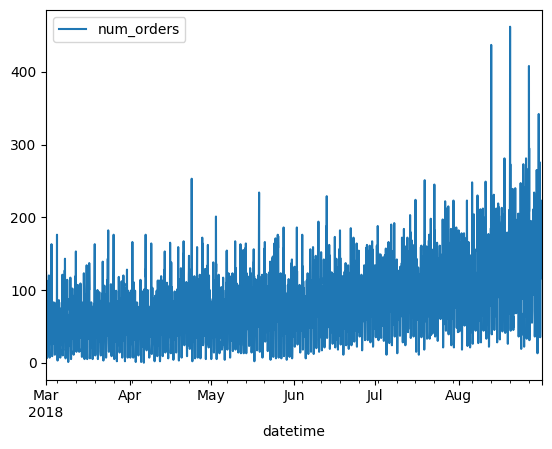

In [11]:
df.plot()

Observamos que los registros tienden a subir con el tiempo, pero no se observa una tendencia clara.

<Axes: xlabel='datetime'>

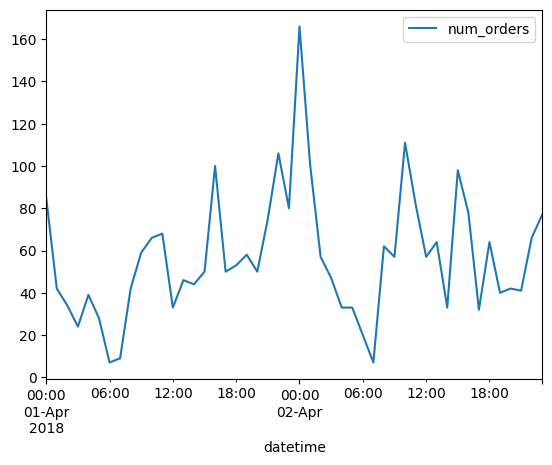

In [15]:
df_sample = df['2018-04-01':'2018-04-02']
df_sample.plot()

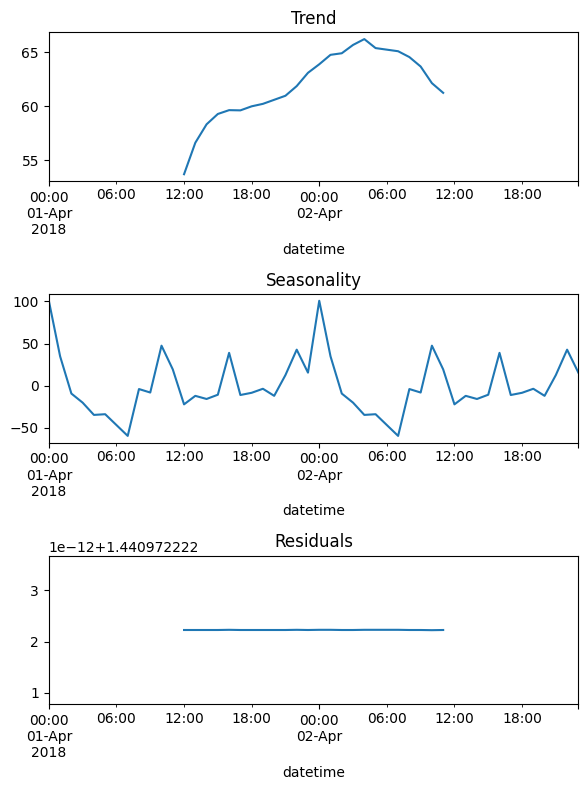

In [14]:
decomposed = seasonal_decompose(df_sample)

plt.figure(figsize=(6, 8))
plt.subplot(311)
# Para mostrar el gráfico de manera correcta, especifica su
# eje ax igual a plt.gca() (gca = obtener el eje actual)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

Al realizar un extracto de 2 días observamos que hay un incremento alrededor de las 12 am.

## Formación

Para este projecto utilizaremos los modelos regresión lineal, árboles de decisión y bosques aleatorios.

Agregamos una función para generar las características.

In [ ]:
def make_features(df, max_lag, rolling_mean_size):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek

    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = (
        df['num_orders'].shift().rolling(rolling_mean_size).mean()
    )


In [ ]:
make_features(df, 6, 10)

train, test = train_test_split(df, shuffle=False, test_size=0.2)
train = train.dropna()

features_train = train.drop(['num_orders'], axis=1)
target_train = train['num_orders']
features_test = test.drop(['num_orders'], axis=1)
target_test = test['num_orders']

### Regresión lineal

In [ ]:
lr = LinearRegression()
lr.fit(features_train, target_train)

pred_test_lr = lr.predict(features_test)
pred_train_lr = lr.predict(features_train)

### Árbol de decisión

In [ ]:
tree = DecisionTreeClassifier()
tree.fit(features_train, target_train)

pred_test_dt = tree.predict(features_test)
pred_train_dt = tree.predict(features_train)

### Bosque aleatorio

In [ ]:
forest = RandomForestClassifier()
forest.fit(features_train, target_train)

pred_test_rf = forest.predict(features_test)
pred_train_rf = forest.predict(features_train)

## Prueba

### Regresión lineal

In [ ]:
print("RECM para el conjunto de entrenamiento:", sqrt(mean_squared_error(target_train,pred_train_lr)))
print("RECM para el conjunto de prueba:", sqrt(mean_squared_error(target_test,pred_test_lr)))

### Árbol de decisión

In [ ]:
print("RECM para el conjunto de entrenamiento:", sqrt(mean_squared_error(target_train,pred_train_dt)))
print("RECM para el conjunto de prueba:", sqrt(mean_squared_error(target_test,pred_test_dt)))

### Bosque aleatorio

In [ ]:
print("RECM para el conjunto de entrenamiento:", sqrt(mean_squared_error(target_train,pred_train_rf)))
print("RECM para el conjunto de prueba:", sqrt(mean_squared_error(target_test,pred_test_rf)))

## Conclusiones

Observamos que para esta aplicación el modelo más adecuado serían **regresión lineal**, ya que es el modelo que nos arroja un menor RECM de **47** para el conjunto de prueba, lo cual es inferior a los solicitado de 48 por la descripción del proyecto.

# Lista de revisión

- [x]  Jupyter Notebook está abierto.<br>
- [x]  El código no tiene errores<br>
- [x]  Las celdas con el código han sido colocadas en el orden de ejecución.<br>
- [x]  Los datos han sido descargados y preparados.<br>
- [x]  Se ha realizado el paso 2: los datos han sido analizados<br>
- [x]  Se entrenó el modelo y se seleccionaron los hiperparámetros<br>
- [x]  Se han evaluado los modelos. Se expuso una conclusión<br>
- [x] La *RECM* para el conjunto de prueba no es más de 48